### Введение:
Был получен набор данных и задача - построить модель машинного обучения, которая для снижения затрат на энергопотребление будет предсказывать температуру стали на последнем цикле.
### План работы:
1. Загрузить и проанализировать данные, понять какие понадобятся для обучения, а какие - нет.
2. Из подходящих данных выделить признаки для обучения моделей.
3. Построить несколько моделей обучения с разными гиперпараметрами для выявления лучшей модели. Метрика заказчика - МАЕ.
4. Лучшие результаты проверить на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

Данные загружены, каждый датасет я буду анализировать отдельно, чтобы в конце - сложилась общая картина как о процессе, так и о данных, которые нужно будет сводить в таблицу, что пойдёт на машинное обучение. Как сказал Гагарин: "Поехали!".

Пишем функцию для первичного знакомства с данными, чтобы облегчить код:

In [3]:
def first_view(data):
    print(data.info()) 
    print ('Количество дупликатов, строки:', data.duplicated().sum())
    return data.head(10)

## Данные об электродах

In [4]:
first_view(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
Количество дупликатов, строки: 0


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Видим, что в таблице есть два столба с временными показателями, приводим их к корректному типу, а именно datetime.

In [5]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим на распределение показателей активной и реактивной мощности.

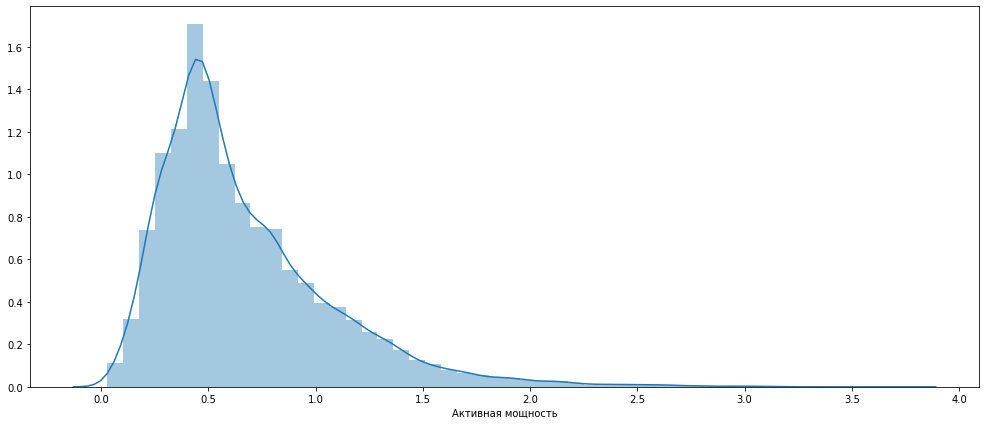

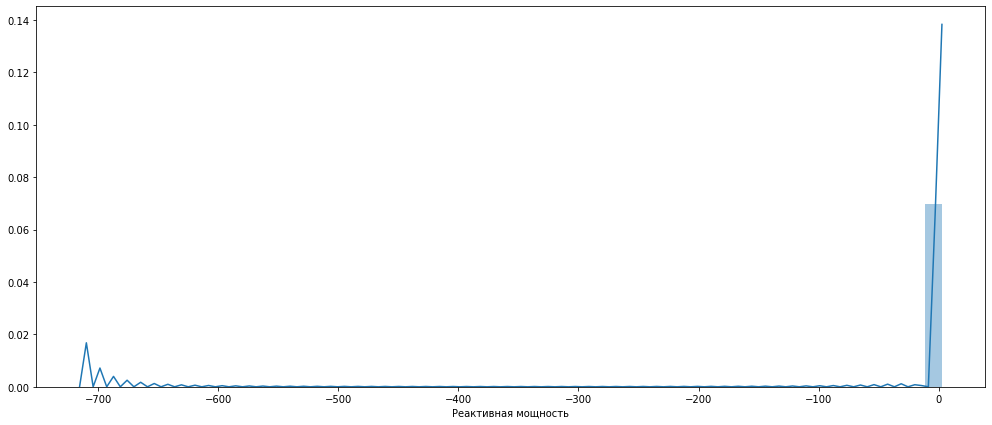

In [6]:
for column in data_arc.loc[:,'Активная мощность':].columns:
    plt.figure(figsize=(17, 7))
    sns.distplot(data_arc[column])
    plt.show()

Наблюдаем нормальное распределение активной мощности, с хвостом вправо. Показатель реактивной мощности группируется вокруг нуля, есть, скорее всего, аномалия с пиком на - 700, судя по остальным значениям. Посмотрим её ближе на ящике.

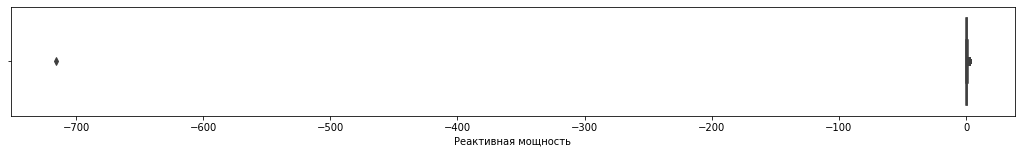

In [7]:
plt.figure(figsize=(18,2))
sns.color_palette()
sns.boxplot(data_arc['Реактивная мощность']);

Очевидная потребность - увеличить масштаб -> выполняем.

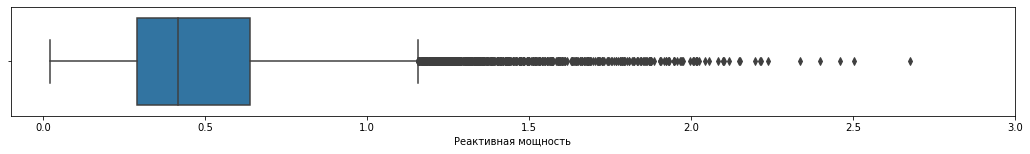

In [8]:
plt.figure(figsize=(18,2))
sns.boxplot(data_arc['Реактивная мощность'])
plt.xlim(-0.1,3);

Посмотрев ящики, смело делаем вывод, что -700 это выброс, нормальные показатели лежат на положительной оси, < 3. Остальные значения (неположительные) - удаляем, чтобы получиться нормальное распределение реактивной мощности.

In [9]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

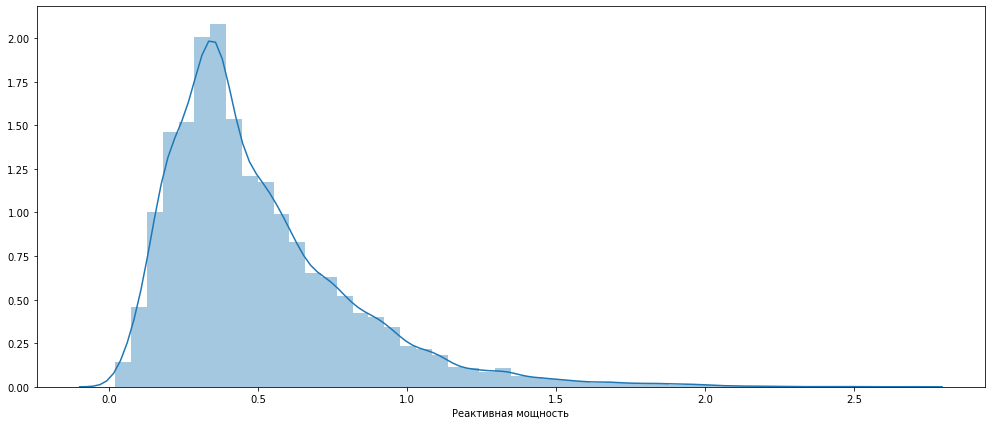

In [10]:
plt.figure(figsize=(17, 7))
sns.distplot(data_arc['Реактивная мощность']);

## Данные о подаче сыпучих материалов (объём)

In [11]:
first_view(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
Количество дупликатов, строки: 0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


"Нет" - заглавным буквам и пробелам в названии столбцов, "да" - строчным буквам и нижнему подчёркиванию. Меняем.

In [12]:
data_bulk.columns = (data_bulk.columns.str.lower()).str.replace(' ', '_')
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
data_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

"Многовато будет" пропусков. В данном случае, пропуск можно интерпретировать как отсутствие изменения объема - т.е. сыпучие материалы не были добавлены. Логично заменить пропуски - нулями. Заодно приведём значения к целочисленному типу.

In [14]:
data_bulk = data_bulk.fillna(0).astype('int')
data_bulk.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [15]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропуски обработали, ввели целочисленные значения, едем дальше. 

## Данные о подаче сыпучих материалов (время)

In [16]:
first_view(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
Количество дупликатов, строки: 0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [17]:
data_bulk_time.columns = (data_bulk_time.columns.str.lower()).str.replace(' ', '_')
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Видим столбцы с показателями времени, приводим их к типу datetime.

In [18]:
for column in data_bulk_time.columns[1:]:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
bulk_1     252 non-null datetime64[ns]
bulk_2     22 non-null datetime64[ns]
bulk_3     1298 non-null datetime64[ns]
bulk_4     1014 non-null datetime64[ns]
bulk_5     77 non-null datetime64[ns]
bulk_6     576 non-null datetime64[ns]
bulk_7     25 non-null datetime64[ns]
bulk_8     1 non-null datetime64[ns]
bulk_9     19 non-null datetime64[ns]
bulk_10    176 non-null datetime64[ns]
bulk_11    177 non-null datetime64[ns]
bulk_12    2450 non-null datetime64[ns]
bulk_13    18 non-null datetime64[ns]
bulk_14    2806 non-null datetime64[ns]
bulk_15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [19]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Эта таблица аналогична предыдущей. Только здесь указано время ввода добавок. Скорее всего эта таблица нам не понадобится.

## Данные о продувке сплава газом

In [20]:
first_view(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
Количество дупликатов, строки: 0


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Название столбца о продувке газом - к латинице приводим.

In [21]:
data_gas.columns = ['key','gas_1']
data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
data_gas.isna().sum()

key      0
gas_1    0
dtype: int64

In [23]:
data_gas.duplicated().sum()

0

In [24]:
data_gas['gas_1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

Посмотрим, чего по распределению после обзорных данных на графиках.

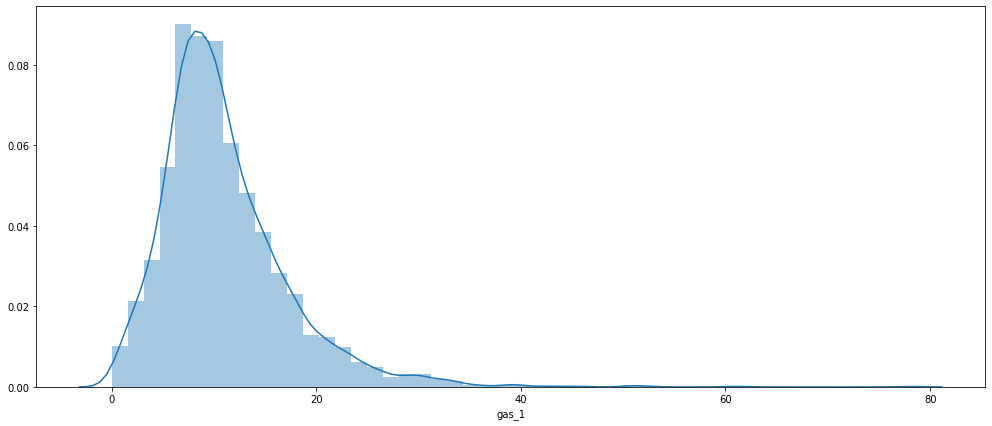

In [25]:
plt.figure(figsize=(17,7))
sns.distplot(data_gas['gas_1']);

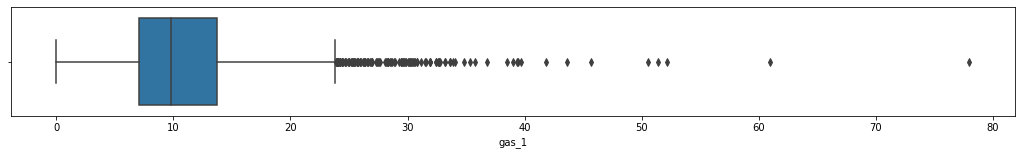

In [26]:
plt.figure(figsize=(18,2))
sns.boxplot(data_gas['gas_1']);

Уверенное затухание происходит после отметки в 40 единиц. Основные показатели находятся в пределе ~23. Однако, не всё что аномально - ненормально. Оставим данные с запасом, чтобы не убрать естественные выбросы процесса. 

In [27]:
data_gas =data_gas.query('gas_1 <=40')

## Результаты измерения температуры

In [28]:
first_view(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
Количество дупликатов, строки: 0


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Из кириллицы - в латиницу, из object'а - в datetime.

In [29]:
data_temp.columns = ['key', 'measurement_time', 'temperature']

In [30]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

Извлечём из данных последнюю температуру для каждой партии.

In [31]:
temp_sort = data_temp.sort_values(['key', 'measurement_time'], ascending=[True, False])
temp_sort.head()

,key,measurement_time,temperature
4,1,2019-05-03 11:30:39,1613.0
3,1,2019-05-03 11:30:01,1601.0
2,1,2019-05-03 11:29:11,1618.0
1,1,2019-05-03 11:25:53,1604.0
0,1,2019-05-03 11:16:18,1571.0


In [32]:
temp_sort = temp_sort.drop_duplicates('key').reset_index(drop=True)
temp_sort.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


In [33]:
temp_sort['temperature'].isna().sum()

739

Не все замеры прошли удачно. В некоторых партиях последняя температура отсутствует и таких строк довольно много ~ 23%. Замена пустых значений на среднее приведет к искажению данных, лучше такие строки удалить.

In [34]:
temp_sort.dropna(inplace=True)

In [35]:
temp_sort.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


Займёмся теперь начальными температурами.

In [36]:
temp_sort_start = data_temp.sort_values(['key', 'measurement_time'], ascending=True)

In [37]:
temp_sort_start = temp_sort_start.drop_duplicates('key').reset_index(drop=True)

In [38]:
temp_sort_start['temperature'].isna().sum()

0

In [39]:
temp_sort_start.columns = ['key', 'times', 'temperature_start']

In [40]:
temp_sort_start.head()

,key,times,temperature_start
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


Посмотрим распределение температуры на графиках.

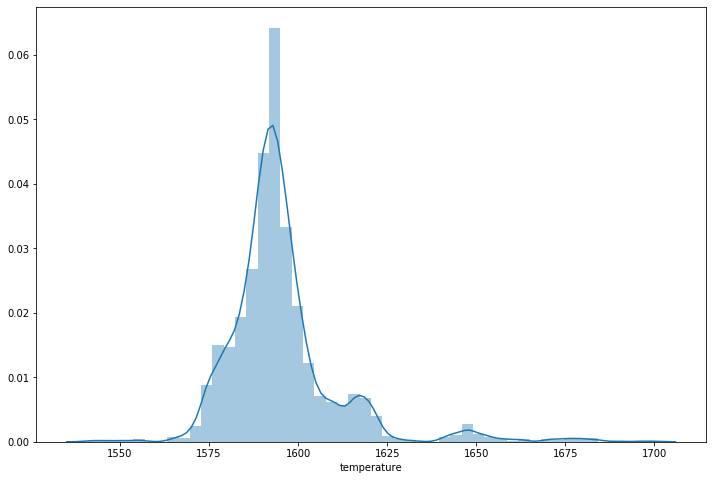

In [41]:
plt.figure(figsize=(12,8))
sns.distplot(temp_sort['temperature']);

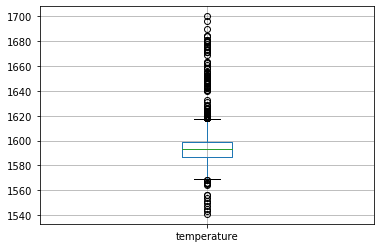

In [42]:
temp_sort.boxplot(column='temperature')


Убирать хвост справа по показателям было бы неверным, распределение похоже на нормальное, а значения, которые немного выбиваются - стоит оставить, чтобы получить не модель-песочницу ML.

## Данные о проволочных материалах (объём)

In [45]:
first_view(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
Количество дупликатов, строки: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_wire.columns = (data_wire.columns.str.lower()).str.replace(' ', '_')
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire_for_plot = data_wire.drop(['key'], axis = 1)

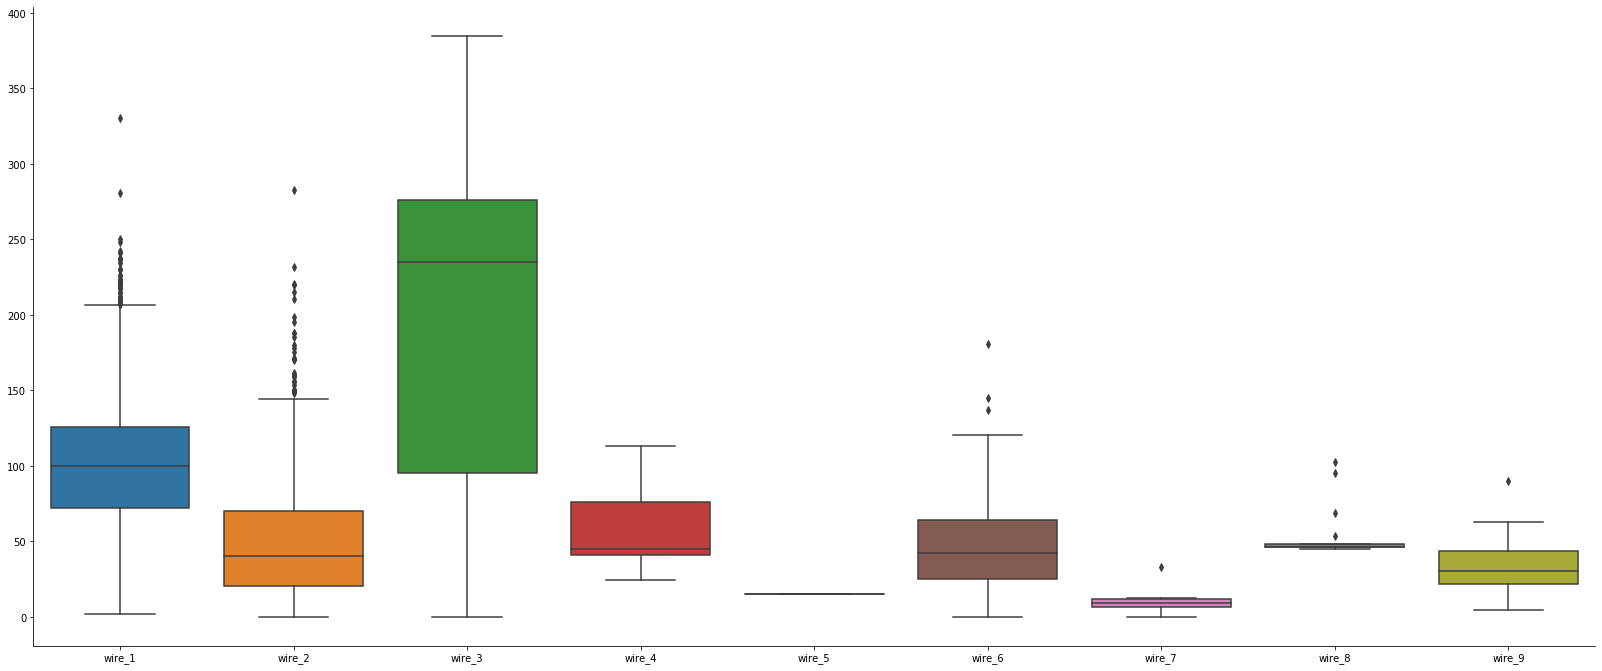

In [48]:
wire_plot = sns.catplot(kind="box", data=data_wire_for_plot);
wire_plot.fig.set_size_inches(25, 10)

Здесь удалять выбросы не будем: разница между максимальным значением и медианным представляется лежащей в разумных пределах. Пропуски заполняем нулями и приводим к целочисленному значению.

In [49]:
data_wire = data_wire.fillna(0).astype('int')

## Данные о проволочных материалах (время)

In [50]:
first_view(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
Количество дупликатов, строки: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_wire_time.columns = (data_wire_time.columns.str.lower()).str.replace(' ', '_time_')
data_wire_time.head()

,key,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
data_wire_time.isna().sum()

key               0
wire_time_1      26
wire_time_2    2002
wire_time_3    3018
wire_time_4    3067
wire_time_5    3080
wire_time_6    3008
wire_time_7    3070
wire_time_8    3062
wire_time_9    3052
dtype: int64

Пропуски оставим без изменения.

## Выводы по предобработке:
Данные проверили.
Почистили от заметных аномалий.
Заполнили пропуски в переменных, в которых можно заполнить нулем руководствуясь логикой.
Объекты с пропусками в целевой переменной удалили.
Далее приступим к извлечению признаков из данных. Следующий шаг -  выделение признаков из данных.

### Выделение признаков из данных

Введём столбец с суммарным количеством всех легирующих элементов в партии.

In [53]:
data_bulk['bulk_sum'] = data_bulk['bulk_1'] + data_bulk['bulk_3'] + data_bulk['bulk_4'] + data_bulk['bulk_5'] + data_bulk['bulk_6'] + data_bulk['bulk_10'] + data_bulk['bulk_11'] + data_bulk['bulk_12'] + data_bulk['bulk_14'] + data_bulk['bulk_15']

In [54]:
data_wire['wire_sum'] = data_wire['wire_1'] + data_wire['wire_2'] + data_wire['wire_1'] + data_wire['wire_3'] + data_wire['wire_6']

In [56]:
temp_sort = temp_sort.merge(temp_sort_start[['temperature_start', 'key']], on='key', how='left')

Начинаем собирать нужные данные для машинного обучения в единую таблицу.

In [57]:
data_for_model = temp_sort[['key', 'temperature', 'temperature_start']].merge(data_bulk, on='key', how='left').merge(data_wire, on='key', how='left').merge(data_gas, on='key', how='left')

In [58]:
data_arc['total_sec'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,total_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


In [59]:
arc_pivot = data_arc.pivot_table(index=['key'], values=['Активная мощность', 'Реактивная мощность', 'total_sec'], aggfunc=['sum'])

In [60]:
arc_pivot.columns = ['delta_sum', 'active_power_sum', 'reactive_power_sum']

In [61]:
arc_pivot.head()

,delta_sum,active_power_sum,reactive_power_sum
key,,,
1,1098,4.878147,3.183241
2,811,3.052598,1.998112
3,655,2.525882,1.599076
4,741,3.209250,2.060298
5,869,3.347173,2.252643


In [62]:
data_for_model = data_for_model.merge(arc_pivot, on='key', how='left')

In [63]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 33 columns):
key                   2477 non-null int64
temperature           2477 non-null float64
temperature_start     2477 non-null float64
bulk_1                2408 non-null float64
bulk_2                2408 non-null float64
bulk_3                2408 non-null float64
bulk_4                2408 non-null float64
bulk_5                2408 non-null float64
bulk_6                2408 non-null float64
bulk_7                2408 non-null float64
bulk_8                2408 non-null float64
bulk_9                2408 non-null float64
bulk_10               2408 non-null float64
bulk_11               2408 non-null float64
bulk_12               2408 non-null float64
bulk_13               2408 non-null float64
bulk_14               2408 non-null float64
bulk_15               2408 non-null float64
bulk_sum              2408 non-null float64
wire_1                2373 non-null float64
wire_2         

Заменим NaN на 0 в датафрейме.

In [64]:
data_for_model = data_for_model.fillna(0)

In [65]:
data_for_model_final = data_for_model[data_for_model['gas_1'] != 0]

Возможно, большое количество нулей в столбцах легирующих элементов будет вставлять палки в колёса при обучении модели. Столбцы, в которых реже всего добавляют элементов (<30 раз за все партии) - убираем.

In [66]:
data_for_model_final = data_for_model_final.drop(['key', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13', 'wire_3', 'wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], axis=1)

Переименовываем столбцы, убирая кириллицу из столбцов мощностей.

In [67]:
data_for_model_final.columns = ['temperature', 'temperature_start', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_sum', 'wire_1', 'wire_2', 'wire_6', 'wire_sum', 'gas_1', 'delta_sum', 'active_power_sum', 'reactive_power_sum']

Выводим число партий, когда легирующие элементы не добавлялись.

In [68]:
data_for_model_final[(data_for_model_final['bulk_sum'] == 0) & (data_for_model_final['wire_sum'] == 0)]['temperature'].count()

29

In [69]:
data_for_model_final = data_for_model_final[(data_for_model_final['bulk_sum'] != 0) | (data_for_model_final['wire_sum'] != 0)]

Такие записи нас мало интересуют, т.к. современные стали всегда легируют. Почему добавка элементов не была зафиксирована - стоит задать вопрос заказчику.

Найдем суммарную мощность и дропнем столбец с реактивной - иначе это будет повторение показателя.

In [70]:
data_for_model_final['power_sum'] = data_for_model_final['active_power_sum'] + data_for_model_final['reactive_power_sum']
data_for_model_final = data_for_model_final.drop('reactive_power_sum', axis=1)

In [71]:
data_for_model_final = data_for_model_final.drop(['bulk_10','bulk_12', 'wire_1', 'delta_sum'], axis=1)

In [72]:
# вот он, язь
data_for_model_final

,temperature,temperature_start,bulk_1,bulk_3,bulk_4,bulk_6,bulk_11,bulk_14,bulk_15,bulk_sum,wire_2,wire_6,wire_sum,gas_1,active_power_sum,power_sum
0,1613.0,1571.0,0.0,0.0,43.0,0.0,0.0,150.0,154.0,553.0,0.0,0.0,120.0,29.749986,4.878147,8.061388
1,1602.0,1581.0,0.0,0.0,73.0,0.0,0.0,149.0,154.0,582.0,0.0,0.0,192.0,12.555561,3.052598,5.050710
2,1599.0,1596.0,0.0,0.0,34.0,0.0,0.0,152.0,153.0,544.0,0.0,0.0,182.0,28.554793,2.525882,4.124958
3,1625.0,1601.0,0.0,0.0,81.0,0.0,0.0,153.0,154.0,595.0,0.0,0.0,178.0,18.841219,3.209250,5.269548
4,1602.0,1576.0,0.0,0.0,78.0,0.0,0.0,151.0,152.0,584.0,9.0,0.0,187.0,5.413692,3.347173,5.599815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,1591.0,1570.0,0.0,21.0,0.0,0.0,0.0,129.0,223.0,719.0,0.0,0.0,178.0,7.125735,3.210690,5.571467
2473,1591.0,1554.0,0.0,0.0,63.0,0.0,0.0,129.0,226.0,796.0,0.0,0.0,228.0,9.412616,4.203064,7.013249
2474,1589.0,1571.0,0.0,0.0,85.0,0.0,0.0,124.0,226.0,665.0,9.0,0.0,197.0,6.271699,2.212379,4.063648
2475,1594.0,1591.0,0.0,90.0,0.0,0.0,0.0,129.0,207.0,733.0,0.0,0.0,236.0,14.953657,3.408725,5.764154


### Построение модели

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb

In [74]:
features_train, features_test, target_train, target_test = train_test_split(
    data_for_model_final.drop('temperature', axis=1), data_for_model_final.temperature, test_size=0.25, random_state=12345)

In [75]:
model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
predict_reg = model_reg.predict(features_test)
mean_absolute_error(target_test, predict_reg)

7.424120616953514

In [76]:
pool_cat = Pool(data=features_train,
              label=target_train)

In [77]:
pool_test = Pool(data=features_test, label=target_test)

In [78]:
model_catboost = CatBoostRegressor(iterations=22000,
         depth=4,
         loss_function='MAE',
         learning_rate=0.001,
         verbose=20,
         random_state=12345)

In [79]:
model_catboost.fit(pool_cat)

0:	learn: 9.3828372	total: 48.7ms	remaining: 17m 51s
20:	learn: 9.3433144	total: 236ms	remaining: 4m 6s
40:	learn: 9.3050035	total: 441ms	remaining: 3m 56s
60:	learn: 9.2625452	total: 628ms	remaining: 3m 45s
80:	learn: 9.2215451	total: 823ms	remaining: 3m 42s
100:	learn: 9.1836737	total: 1.01s	remaining: 3m 39s
120:	learn: 9.1419842	total: 1.21s	remaining: 3m 38s
140:	learn: 9.1053236	total: 1.39s	remaining: 3m 36s
160:	learn: 9.0672394	total: 1.59s	remaining: 3m 35s
180:	learn: 9.0306840	total: 1.78s	remaining: 3m 35s
200:	learn: 8.9955101	total: 1.97s	remaining: 3m 33s
220:	learn: 8.9590287	total: 2.25s	remaining: 3m 41s
240:	learn: 8.9247980	total: 2.44s	remaining: 3m 40s
260:	learn: 8.8892129	total: 2.63s	remaining: 3m 39s
280:	learn: 8.8550536	total: 2.74s	remaining: 3m 31s
300:	learn: 8.8214036	total: 3.02s	remaining: 3m 37s
320:	learn: 8.7892101	total: 3.21s	remaining: 3m 36s
340:	learn: 8.7589005	total: 3.41s	remaining: 3m 36s
360:	learn: 8.7285611	total: 3.6s	remaining: 3m 36s

In [80]:
predict = model_catboost.predict(pool_test)

In [81]:
mean_absolute_error(target_test, predict)

6.13154003404077

In [82]:
lgb_params = {'metric': 'mae',
              'objective': 'regression',
             'num_boost_round': 20000,
             'stratified': False,
             'random_state': 12345,
             'max_depth': 6,
             'learning_rate': 0.005}

In [83]:
lgb_data_train = lgb.Dataset(features_train, target_train)


In [84]:
lgb_params_test = {'metric': 'mae',
              'objective': 'regression',
             'stratified': False,
             'random_state': 12345,
             'max_depth': 6,
             'learning_rate': 0.001}

In [ ]:
bst = lgb.train(lgb_params_test, lgb_data_train, num_boost_round=20000)

In [ ]:
predictions_lgb = bst.predict(features_test, num_iteration=bst.best_iteration)

In [ ]:
mean_absolute_error(target_test, predictions_lgb)

## Выводы:

- Стоит дать обратную связь заказчику о значимсоти точного измерения температуры в начале процесса. Собственно, DS, получив более точный по замерам таргет - сможет эффективнее эмулировать процессы.
- После EDA было видно, что при каждой партии испольуеются разный состав стали. Это добавляет неудобной определённости для анализа данных. Возможным решением могло бы статть введение технического стандарта процедуры.
- Заказчику же стоит рекомендовать использование модели CatBoost с обозначенными выше параметрами и итоговой метрикой MAE в 6.1, что удолетворяет вводные условия задачи.